# To run if on Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import zipfile
import os

file_name = 'Dataset_TXA.zip'

# copying the dataset to the temporary workspace
print('Copying Dataset to temporary workspace...')
shutil.copyfile('drive/MyDrive/Dataset_TXA.zip', 'Dataset_TXA.zip')
print('Copied...')

# unzipping the dataset
path = 'Dataset'
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(path)

#moving inside the Dataset folder
os.chdir(path)
os.getcwd()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!pip install swifter
!pip install wordcloud
!pip install gensim
!pip install transformers
!pip install spacy
!spacy download en_core_web_sm

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

# Importing the Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import time
from collections import Counter

import requests
from bs4 import BeautifulSoup

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS

import torch
import swifter
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Split the documents into tokens.
from nltk.tokenize import RegexpTokenizer

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(STOPWORDS)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\daddu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\daddu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\daddu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
# cleaning different patterns
def clean_tokens(tokens):
    tokens = re.sub(r'[^\w\s]', '', tokens)
    tokens = re.sub(r'<.*?>', '', tokens) #removing HTMLS
    tokens = re.sub(r"\\", "", tokens) #removing \ character
    tokens = re.sub(r"\n", "", tokens)
    tokens = re.sub(r"http\S+", "", tokens) #removing HTTPS
    tokens = re.sub(r'\b\d+\b', '', tokens) #removing numbers
    
    return tokens.strip().lower()

In [7]:
#cleaning stopwords and words containing non alphanumeric characters
def remove_stop_words(column):
    return [[word for word in ls if (word not in stop_words) and word.isalpha()] for ls in column]

# Loading the Training Set

In [8]:
df = pd.read_csv("gr_training_set.csv")

In [9]:
df.tail(4)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,genre
899996,b9450d1c1f97f891c392b1105959b56e,16095092,e979c735276431915d089cfaf446d64f,3,This was a quick read for me. I have read a lo...,Fri Nov 16 22:09:49 -0800 2012,Sat Nov 17 23:38:58 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,1,1,NaN
899997,b9450d1c1f97f891c392b1105959b56e,8430896,feb9fe6439f9fbba8a1cce36020ad977,4,** spoiler alert ** \n 3.5 stars. \n This book...,Tue Nov 13 05:38:24 -0800 2012,Tue Nov 13 23:29:17 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,1,0,Young Adult
899998,b9450d1c1f97f891c392b1105959b56e,12275680,741e29369f70531bfffbd02add86f228,4,** spoiler alert ** \n Another fun read from M...,Mon Nov 12 05:42:30 -0800 2012,Tue Nov 13 22:32:05 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Mon Nov 12 00:00:00 -0800 2012,0,0,Mystery
899999,b9450d1c1f97f891c392b1105959b56e,17005,d55f3a967230940e75a314700caec9a5,3,** spoiler alert ** \n 3.5 stars \n I liked it...,Sun Nov 11 00:05:43 -0800 2012,Sun Nov 11 21:59:08 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,0,0,Young Adult


# Checking Users' behaviour
If some users reviewed too many books and if the users reviewed the same books more than once

In [6]:
dist_user_reviews = sorted(
                            list(df.user_id.value_counts().items()),
                           key = lambda x: -x[1]) #sorting on count

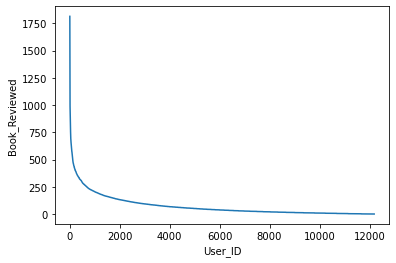

In [7]:
# conclusion: power law of a few users with lots of reviews
plt.plot([x[1] for x in dist_user_reviews])
plt.ylabel('Book_Reviewed')
plt.xlabel('User_ID')
plt.show()

In [8]:
book_per_user = df.groupby(['user_id', 'book_id']).count()['review_id']
book_per_user

user_id                           book_id 
000a1016fda6008d1edbba720ca00851  178476      1
                                  215643      1
                                  458034      1
                                  3863861     1
                                  6040871     1
                                             ..
ffff7cafdaf5196383cb2efca08fb6fe  27161826    1
                                  27272506    1
                                  28260587    1
                                  28954189    1
                                  32571395    1
Name: review_id, Length: 900000, dtype: int64

In [9]:
# no review of the same book
book_per_user.max()

1

# Balancing reviews per book
Sampling reviews pertaining to books with too many reviews

In [10]:
df['n_review_per_book'] = df.groupby('book_id')['book_id'].transform(len)

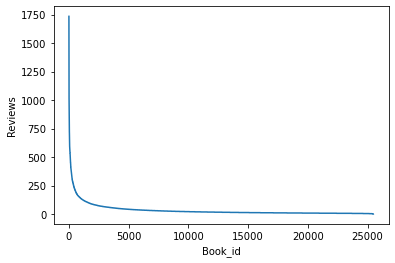

In [11]:
# too many reviews for some books, they need some balancing
reviews_x_book = [x[1] for x in sorted(list(set([(x, y) for x, y in df[['book_id', 'n_review_per_book']].values])),
                                       key = lambda x: -x[1])]
                                       
plt.plot(reviews_x_book)
plt.ylabel('Reviews')
plt.xlabel('Book_id')
plt.show()

In [12]:
#average number of reviews per book
average_rev = int(sum(reviews_x_book) / len(reviews_x_book) // 1)
average_rev

35

In [13]:
indexes_to_keep = df[df['n_review_per_book'] <= average_rev].index
index_sampled = df[df['n_review_per_book'] > average_rev].groupby('book_id').sample(average_rev).index

new_indexes = sorted(indexes_to_keep.tolist()+index_sampled.tolist())

In [14]:
df = df.loc[new_indexes].reset_index(drop=True)
len(df)

501745

# Dropping NaN genres

In [15]:
#Dropping NaN values
print(f"NaN values: {df.genre.isna().sum()}")
df.dropna(subset=['genre'], inplace=True)
print(f"NaN values: {df.genre.isna().sum()}")

NaN values: 71220
NaN values: 0


In [16]:
df_len = len(df)
print(f'New Dataset Length: {df_len}')

New Dataset Length: 430525


# Storing the new training set and cleaning RAM

In [20]:
rev = df[["review_text","genre", "rating", "book_id"]]
#del df

In [21]:
rev.head()

,review_text,genre,rating,book_id
0,This is a special book. It started slow for ab...,Science Fiction,5,18245960
1,Recommended by Don Katz. Avail for free in Dec...,Classics,3,16981
2,"A fun, fast paced science fiction thriller. I ...",Science Fiction,3,28684704
3,Recommended reading to understand what is goin...,Nonfiction,0,27161156
4,"I really enjoyed this book, and there is a lot...",Science Fiction,4,25884323


In [22]:
len(rev)

900000

# Balancing the genres

In [32]:
list(enumerate(rev.genre.value_counts().items()))

[(0, ('Fantasy', 195266)),
 (1, ('Romance', 161726)),
 (2, ('Young Adult', 127018)),
 (3, ('Fiction', 46510)),
 (4, ('Science Fiction', 31945)),
 (5, ('Sequential Art', 26561)),
 (6, ('Mystery', 22738)),
 (7, ('Historical', 17993)),
 (8, ('Classics', 14684)),
 (9, ('Horror', 14285)),
 (10, ('Nonfiction', 9514)),
 (11, ('New Adult', 8976)),
 (12, ('Paranormal', 5294)),
 (13, ('Dark', 5144)),
 (14, ('Thriller', 4305)),
 (15, ('Childrens', 4182)),
 (16, ('Erotica', 3054)),
 (17, ('Contemporary', 2539)),
 (18, ('Womens Fiction', 2416)),
 (19, ('Short Stories', 1964)),
 (20, ('LGBT', 1748)),
 (21, ('Adult Fiction', 1690)),
 (22, ('Sports', 1350)),
 (23, ('Media Tie In', 1320)),
 (24, ('Humor', 1123)),
 (25, ('Poetry', 1090)),
 (26, ('History', 557)),
 (27, ('Plays', 452)),
 (28, ('Christian Fiction', 318)),
 (29, ('Realistic Fiction', 289)),
 (30, ('Autobiography', 243)),
 (31, ('Reference', 196)),
 (32, ('Science', 175)),
 (33, ('Anthologies', 146)),
 (34, ('Polyamorous', 146)),
 (35, ('Wa

In [27]:
new_genres = { frozenset({"Fantasy", "Superheroes", "Shapeshifters", "Science Fiction Fantasy"}) :"Fantasy" ,
               frozenset({"Romance", "Erotica", "Polyamorous", "Category Romance"}) : "Romance",
               frozenset({"Fiction", "Young Adult", "New Adult", "Womens Fiction", 
                          "Adult Fiction", "Christian Fiction", "Realistic Fiction",
                          "Fan Fiction", "Magical Realism"}) : "Fiction",
               frozenset({"Sequential Art", "Music", "Couture"}) : "Art",
               frozenset({"Thriller", "Mystery", "Crime"}) : "Thriller",
               frozenset({"Science Fiction"}) : "Science Fiction",
               frozenset({"Horror", "Paranormal", "Dark", "Suspense"}) : "Horror",
               frozenset({"Classics", "Contemporary", "Poetry", "Plays"}) : "Literature",
               frozenset({"Nonfiction", "Autobiography", "Biography"}) : "NonFiction",
               frozenset({"Historical", "History", "War", "Mythology"}) : "History",
             }

In [28]:
#list of genres that can't be aggregate
genres_to_keep_dict = {genre:val for lista,val in new_genres.items() for genre in lista}
genres_to_keep_dict

{'Superheroes': 'Fantasy',
 'Fantasy': 'Fantasy',
 'Shapeshifters': 'Fantasy',
 'Science Fiction Fantasy': 'Fantasy',
 'Polyamorous': 'Romance',
 'Erotica': 'Romance',
 'Category Romance': 'Romance',
 'Romance': 'Romance',
 'Fiction': 'Fiction',
 'Magical Realism': 'Fiction',
 'Fan Fiction': 'Fiction',
 'Womens Fiction': 'Fiction',
 'Christian Fiction': 'Fiction',
 'New Adult': 'Fiction',
 'Realistic Fiction': 'Fiction',
 'Young Adult': 'Fiction',
 'Adult Fiction': 'Fiction',
 'Sequential Art': 'Art',
 'Music': 'Art',
 'Couture': 'Art',
 'Mystery': 'Thriller',
 'Crime': 'Thriller',
 'Thriller': 'Thriller',
 'Science Fiction': 'Science Fiction',
 'Dark': 'Horror',
 'Horror': 'Horror',
 'Suspense': 'Horror',
 'Paranormal': 'Horror',
 'Classics': 'Literature',
 'Plays': 'Literature',
 'Contemporary': 'Literature',
 'Poetry': 'Literature',
 'Autobiography': 'NonFiction',
 'Nonfiction': 'NonFiction',
 'Biography': 'NonFiction',
 'History': 'History',
 'Historical': 'History',
 'Mythology': 

In [29]:
print(f"Initial rows: {len(rev)}")
rev = rev[rev.genre.isin(genres_to_keep_dict.keys())].reset_index(drop=True)
print(f"Filtered len: {len(rev)}")

Initial rows: 900000
Filtered len: 705394


In [30]:
rev.genre = rev.genre.map(lambda genere: genres_to_keep_dict[genere])
rev.head()

,review_text,genre,rating,book_id
0,This is a special book. It started slow for ab...,Science Fiction,5,18245960
1,Recommended by Don Katz. Avail for free in Dec...,Literature,3,16981
2,"A fun, fast paced science fiction thriller. I ...",Science Fiction,3,28684704
3,Recommended reading to understand what is goin...,NonFiction,0,27161156
4,"I really enjoyed this book, and there is a lot...",Science Fiction,4,25884323


In [31]:
rev.genre.value_counts()

Fantasy            195350
Fiction            187297
Romance            164979
Science Fiction     31945
Thriller            27136
Art                 26594
Horror              24739
History             18802
Literature          18765
NonFiction           9787
Name: genre, dtype: int64

# Class Undersampling

In [32]:
n = 2000
msk = rev.groupby('genre')['genre'].transform(len) >= n
rev2 = pd.concat((rev[msk].groupby('genre').sample(n=n), rev[~msk]), ignore_index=True)

In [33]:
rev2.genre.value_counts()

Art                2000
Fantasy            2000
Fiction            2000
History            2000
Horror             2000
Literature         2000
NonFiction         2000
Romance            2000
Science Fiction    2000
Thriller           2000
Name: genre, dtype: int64

# Plotting Genres distribution

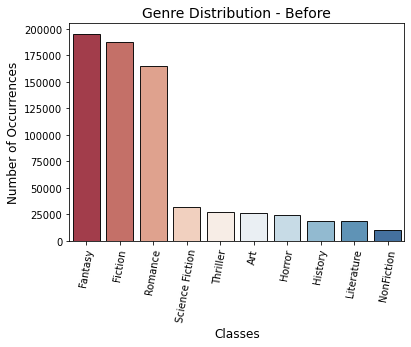

In [34]:
sns.barplot([x for x in rev.genre.value_counts().index],
            [y for y in rev.genre.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - Before',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=80)
plt.show()

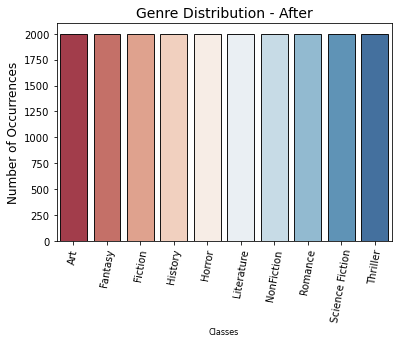

In [35]:
sns.barplot([x for x in rev2.genre.value_counts().index],
            [y for y in rev2.genre.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - After',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=8)
plt.xticks(rotation=80)
plt.show()

In [36]:
#cleaning review_text col
rev = rev2
rev.review_text = rev.review_text.swifter.apply(lambda x: clean_tokens(x))
rev.head()

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

,review_text,genre,rating,book_id
0,fairly realistic given the subject matter of h...,Art,3,6465707
1,like the usual ones the rift did not give an i...,Art,4,18687079
2,i really liked this one great illustrations al...,Art,0,13541584
3,a weaker finish to the story than i had hoped ...,Art,3,17824758
4,i just dont like synder i keep trying when i s...,Art,2,31383622


# Tokeninzing Text

In [129]:
rev["tokenized_text"] = rev.review_text.swifter.apply(lambda x: word_tokenize(x))
rev.head()

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

,review_text,genre,rating,book_id,tokenized_text
0,now this series is heating up at this point th...,Art,5,437093,"[now, this, series, is, heating, up, at, this,..."
1,blew through this thang in about an hour but s...,Art,4,22358444,"[blew, through, this, thang, in, about, an, ho..."
2,i loved this tribe what a great story about be...,Art,4,22504701,"[i, loved, this, tribe, what, a, great, story,..."
3,some shocking things made this volume really good,Art,5,1085771,"[some, shocking, things, made, this, volume, r..."
4,stars i definitely didnt enjoy this as much a...,Art,3,29989615,"[stars, i, definitely, didnt, enjoy, this, as,..."


In [130]:
# Removing Stop Words
print(f"Token list len before: {len(rev.tokenized_text[0])}")
rev["fixed_tokenized_text"] = remove_stop_words(rev["tokenized_text"])
print(f"Token list len after: {len(rev.fixed_tokenized_text[0])}")

Token list len before: 162
Token list len after: 70


In [131]:
rev.head()

,review_text,genre,rating,book_id,tokenized_text,fixed_tokenized_text
0,now this series is heating up at this point th...,Art,5,437093,"[now, this, series, is, heating, up, at, this,...","[series, heating, point, inspiration, sandman,..."
1,blew through this thang in about an hour but s...,Art,4,22358444,"[blew, through, this, thang, in, about, an, ho...","[blew, thang, hour, story, threads, aint, tied..."
2,i loved this tribe what a great story about be...,Art,4,22504701,"[i, loved, this, tribe, what, a, great, story,...","[loved, tribe, great, story, opposed, pair, be..."
3,some shocking things made this volume really good,Art,5,1085771,"[some, shocking, things, made, this, volume, r...","[shocking, things, volume, good]"
4,stars i definitely didnt enjoy this as much a...,Art,3,29989615,"[stars, i, definitely, didnt, enjoy, this, as,...","[stars, definitely, didnt, enjoy, previous, vo..."


In [132]:
# minimum length of the remaining words of the fixed tokenized text 
min([min(x) for x in rev["fixed_tokenized_text"].map(lambda x: ([len(el) for el in x])) if x != []])

1

In [133]:
#filtering the words with a length less than 4
rev["fixed_tokenized_text"] = rev["fixed_tokenized_text"].map(lambda x: [el for el in x if len(el) > 3])

In [134]:
# minimum length of the remaining words of the fixed tokenized text after update
min([min(x) for x in rev["fixed_tokenized_text"].map(lambda x: ([len(el) for el in x])) if x != []])

4

### Extracting vocabulary 

In [135]:
dict_count = dict(sorted(nltk.FreqDist([parola for testo in rev["fixed_tokenized_text"] for parola in testo]).items(), 
                         key=lambda x: x[1], reverse=True))

In [136]:
list(dict_count.items())[:6]

[('book', 33517),
 ('read', 15809),
 ('like', 15119),
 ('story', 14270),
 ('love', 9541),
 ('characters', 8937)]

In [137]:
# filtering out the extreme of the distribution
maximum_threshold = np.quantile(list(dict_count.values()), 0.99)

In [138]:
dict_count_fixed = {k:v for k,v in dict_count.items() if v > 5 and v < maximum_threshold}
# dict_count_fixed

In [139]:
vocabulary = set(dict_count_fixed.keys())
# vocabulary
len(vocabulary)

16170

# Sentiment Analysis on Sample

In [140]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [141]:
sample_sentiment = rev["fixed_tokenized_text"].sample(500, random_state = 42)
sample_sentiment = sample_sentiment.apply(lambda x: ' '.join(x))
index_sample = sample_sentiment.index

In [142]:
start = time.time()
sentiment_score(sample_sentiment.loc[index_sample[0]])
end = time.time()
print(end-start)

1.0032196044921875


In [143]:
sentiment_result = sample_sentiment.swifter.apply(lambda x: sentiment_score(x[:512]))

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [161]:
sentiment_df = pd.concat((rev['review_text'].loc[index_sample], sentiment_result), axis= 1).rename(columns={"fixed_tokenized_text":"sentiment"}).reset_index(drop=True)

In [162]:
sentiment_df.head()

,review_text,sentiment
0,under any normal circumstances id never ever c...,2
1,holy cow this book totally lived up to the hyp...,5
2,tegen was too much of a bitch for me to enjoy ...,4
3,i love clint sofuckingmuch,5
4,this book gave me a lot to not think about it...,2


In [168]:
sentiment_df.loc[sentiment_df.index[0]]['review_text'], sentiment_df.loc[sentiment_df.index[0]]['sentiment']

('under any normal circumstances id never ever consider reading a ya or according to some na  new adult novel about a teenage girl having a relationship with her teacher but this has had such rave reviews on goodreads i was persuaded into giving it a look then i read the first page and i really liked it which explains why its stuck around my toread list so long descriptions like this   it was the kind of greenhouse august heat that feels positively jurassic everything was melting a little the liquid black sky the silver gelpenned stars the neon lights bleeding color everywhere   seemed perfectly pitched lyrical and lovely at the same time as actually sounding like the way a teenager would express themselves  but then i started reading on and it all went downhill into the usual things that annoy me about ya the bynumbers teenspeak and conversely a character who seems to have the life experience wisdom and sexual jadedness of a 35yearold but is meant to be  it seems by all accounts to be

In [169]:
sentiment_df.loc[sentiment_df.index[1]]['review_text'], sentiment_df.loc[sentiment_df.index[1]]['sentiment']

('holy cow this book totally lived up to the hype for me ill be honestit sat on my tbr shelf for quite a while before i convinced myself to pick it up and read it mostly because i was afraid of that hype actually i tend to become resistant to doing said hyped thingmeabobber however i was hugely satisfied with this storyand want more ill even ask nicely my favorite part of the story besides the amazing worldbuilding and fantastic story was the friendship between the two girls in fact my only big quibble with this book is that we didnt get enough of them seriously lets ditch the povs of the boys and stick with the girls that would make me ecstatic excellent ya fantasy  stars',
 5)

# Spacy

In [ ]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

In [ ]:
doc = nlp(" ".join(rev.fixed_tokenized_text[1]))
print(doc[:100])

### Entities

In [ ]:
for entity in doc.ents:
    print(entity.text, entity.label_)

In [ ]:
doc.ents

In [ ]:
from spacy import displacy

displacy.render(doc, style="ent")

# WorldCloud

In [ ]:
def plot_cloud_rating(df, rating):
    review = rev[rev.rating == rating]["review_text"]
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(review.values[0])
    plt.figure(figsize=(15,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
review = rev[rev.rating == 1]["review_text"]
review[:5]

In [ ]:
plot_cloud_rating(rev, 5)

In [ ]:
def frequency_per_genre(df, genre):
    df_review = df[df.genre == genre]
    
    tokenized_text = word_tokenize(" ".join([el for el in df_review["review_text"]]))
    
    frequency_distribution = dict(sorted(nltk.FreqDist(
    [parola for parola in tokenized_text if parola not in stop_words and parola.isalpha()]).items(), 
                                     key=lambda x:x[1], 
                                     reverse= True))
    return frequency_distribution
    
def plot_cloud_genre(df, genre = None, freq_dist_new = None):
    if not freq_dist_new:
        freq_dist_new = frequency_per_genre(df, genre)
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq_dist_new)
    plt.figure(figsize=(15,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
plot_cloud_genre(rev, "Science Fiction")

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_text(" ".join([parola for lista in rev[rev.genre == "Science Fiction"]["fixed_tokenized_text"] for parola in lista]))
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_text(" ".join([el for el in rev[rev.genre == "Romance"]["review_text"]]))
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()